<a href="https://colab.research.google.com/github/Spandan-139/MALPROJ-RE/blob/main/MALPROJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post-Earthquake Soil Erosion Rate Analysis (Ranau, Sabah)
**Method:** RUSLE-based multi-temporal erosion mapping  
**Study Goal:** quantify post-earthquake erosion change, assess 5-year trend, and map high-risk zones.

## Objectives
1. **Immediate impact:** quantify changes in soil erosion rates in Ranau following the earthquake using satellite/derived layers.
2. **Long-term impact:** assess erosion trends over a **five-year period** after the earthquake.
3. **Hotspot mapping:** identify and map **high-risk erosion zones** and derive soil conservation recommendations.


In [ ]:
!pip -q install geopandas rasterio shapely fiona pyproj pandas numpy

import os, zipfile, glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import rasterize

In [ ]:
dem_path = "dem_ranau.tif"

lulc_shp = None
soil_shp = None
for shp in glob.glob("*.shp"):
    up = shp.upper()
    if "LAND" in up:
        lulc_shp = shp
    if "SOIL" in up:
        soil_shp = shp

print("DEM:", dem_path)
print("LULC:", lulc_shp)
print("SOIL:", soil_shp)

assert os.path.exists(dem_path), "Missing dem_ranau.tif"
assert lulc_shp is not None, "Missing landuse .shp"
assert soil_shp is not None, "Missing soil .shp"

DEM: dem_ranau.tif
LULC: RANAU_LANDUSE.shp
SOIL: RANAU_SOIL TYPE.shp


In [ ]:
with rasterio.open(dem_path) as dem:
    dem_meta = dem.meta.copy()
    dem_crs = dem.crs
    dem_transform = dem.transform
    dem_shape = (dem.height, dem.width)
    dem_bounds = dem.bounds

print("DEM CRS:", dem_crs)
print("DEM transform:", dem_transform)
print("DEM shape:", dem_shape)
print("DEM bounds:", dem_bounds)

DEM CRS: EPSG:29873
DEM transform: | 30.91, 0.00, 749953.44|
| 0.00,-30.91, 695773.79|
| 0.00, 0.00, 1.00|
DEM shape: (2790, 2382)
DEM bounds: BoundingBox(left=749953.4415983319, bottom=609545.2981918085, right=823572.1790821675, top=695773.794237107)


In [ ]:
lulc = gpd.read_file(lulc_shp)
soil = gpd.read_file(soil_shp)

print("LULC CRS:", lulc.crs)
print("SOIL CRS:", soil.crs)

lulc = lulc.to_crs(dem_crs)
soil = soil.to_crs(dem_crs)

print("Reprojected LULC CRS:", lulc.crs)
print("Reprojected SOIL CRS:", soil.crs)

LULC CRS: PROJCS["Timbalai 1948 / RSO Borneo (m)",GEOGCS["Timbalai 1948",DATUM["Timbalai_1948",SPHEROID["Everest 1830 (1967 Definition)",6377298.556,300.8017,AUTHORITY["EPSG","7016"]],AUTHORITY["EPSG","6298"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Hotine_Oblique_Mercator"],PARAMETER["latitude_of_center",4],PARAMETER["longitude_of_center",115],PARAMETER["azimuth",53.3158204790862],PARAMETER["rectified_grid_angle",53.130102354156],PARAMETER["scale_factor",0.99984],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
SOIL CRS: PROJCS["Timbalai 1948 / RSO Borneo (m)",GEOGCS["Timbalai 1948",DATUM["Timbalai_1948",SPHEROID["Everest 1830 (1967 Definition)",6377298.556,300.8017,AUTHORITY["EPSG","7016"]],AUTHORITY["EPSG","6298"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Hotine_Oblique_Mercator"],PARAMETER["latitude_of_center",4],PARAMETER["longitu

In [ ]:
# ---- LULC encoding ----
LULC_TEXT_FIELD = "LAND_USE"
lulc[LULC_TEXT_FIELD] = lulc[LULC_TEXT_FIELD].astype(str).fillna("UNKNOWN").str.strip()
lulc["LULC_ID"] = lulc[LULC_TEXT_FIELD].astype("category").cat.codes + 1  # 1..N, 0 reserved for nodata
lulc_lookup = lulc[[LULC_TEXT_FIELD, "LULC_ID"]].drop_duplicates().sort_values("LULC_ID")
lulc_lookup.to_csv("lulc_id_lookup.csv", index=False)

print("LULC lookup:\n", lulc_lookup)

# ---- SOIL encoding ----
SOIL_TEXT_FIELD = "Siri_Tanah"
soil[SOIL_TEXT_FIELD] = soil[SOIL_TEXT_FIELD].astype(str).fillna("UNKNOWN").str.strip()
soil["SOIL_ID"] = soil[SOIL_TEXT_FIELD].astype("category").cat.codes + 1
soil_lookup = soil[[SOIL_TEXT_FIELD, "SOIL_ID"]].drop_duplicates().sort_values("SOIL_ID")
soil_lookup.to_csv("soil_id_lookup.csv", index=False)

print("\nSoil lookup:\n", soil_lookup)

LULC lookup:
     LAND_USE  LULC_ID
2      hutan        1
0  membangun        2
3  pertanian        3
1     tandus        4

Soil lookup:
    Siri_Tanah  SOIL_ID
0   Bidu Bidu        1
1    Brantian        2
2     Crocker        3
3       Dalit        4
4     Kepayan        5
5       Labau        6
6       Lokan        7
7     Malubok        8
8    Mentapok        9
9     Pinosuk       10
10   Trusmadi       11


In [ ]:
def rasterize_to_dem(gdf, value_field, out_path, dem_meta, fill=0, dtype="uint16"):
    # clean rows
    gdf = gdf.dropna(subset=["geometry", value_field]).copy()
    gdf = gdf[~gdf.geometry.is_empty].copy()
    # fix invalid geometries
    gdf["geometry"] = gdf.geometry.buffer(0)

    shapes = [(geom, int(val)) for geom, val in zip(gdf.geometry, gdf[value_field]) if geom is not None and not geom.is_empty]

    out = rasterize(
        shapes=shapes,
        out_shape=(dem_meta["height"], dem_meta["width"]),
        transform=dem_meta["transform"],
        fill=fill,
        dtype=dtype,
        all_touched=True
    )

    meta = dem_meta.copy()
    meta.update({"dtype": dtype, "count": 1, "nodata": fill, "compress": "lzw"})

    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(out, 1)

    return out_path

lulc_out = "RANAU_LANDUSE_FIXED.tif"
soil_out = "RANAU_SOIL_FIXED.tif"

rasterize_to_dem(lulc, "LULC_ID", lulc_out, dem_meta, fill=0, dtype="uint16")
rasterize_to_dem(soil, "SOIL_ID", soil_out, dem_meta, fill=0, dtype="uint16")

print("Saved:", lulc_out, soil_out)

Saved: RANAU_LANDUSE_FIXED.tif RANAU_SOIL_FIXED.tif


In [ ]:
def check_raster(path):
    with rasterio.open(path) as src:
        arr = src.read(1)
        u = np.unique(arr)
        print("File:", path)
        print(" CRS:", src.crs)
        print(" Transform:", src.transform)
        print(" Unique values (first 30):", u[:30], "count=", len(u))
        print(" Non-zero pixels:", int((arr != 0).sum()))
        print()

check_raster(lulc_out)
check_raster(soil_out)

File: RANAU_LANDUSE_FIXED.tif
 CRS: EPSG:29873
 Transform: | 30.91, 0.00, 749953.44|
| 0.00,-30.91, 695773.79|
| 0.00, 0.00, 1.00|
 Unique values (first 30): [0 1 2 3 4] count= 5
 Non-zero pixels: 448058

File: RANAU_SOIL_FIXED.tif
 CRS: EPSG:29873
 Transform: | 30.91, 0.00, 749953.44|
| 0.00,-30.91, 695773.79|
| 0.00, 0.00, 1.00|
 Unique values (first 30): [ 0  1  2  3  4  5  6  7  8  9 10 11] count= 12
 Non-zero pixels: 447956



In [ ]:
from google.colab import files
files.download(lulc_out)
files.download(soil_out)
files.download("lulc_id_lookup.csv")
files.download("soil_id_lookup.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Part B

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject
from rasterio.enums import Resampling as ResampEnum
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [ ]:
DEM_PATH   = r"dem_ranau.tif"
LULC_PATH  = r"RANAU_LANDUSE_FIXED.tif"
SOIL_PATH  = r"RANAU_SOIL_FIXED.tif"

LULC_LUT   = r"lulc_id_lookup.csv"
SOIL_LUT   = r"soil_id_lookup.csv"

RAIN_CSV   = r"slot1_clean.csv"

OUT_DIR = r"ranau_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

OUT_DIR: ranau_outputs


In [ ]:
def read_raster(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        prof = src.profile.copy()
        nod = src.nodata
    if nod is not None:
        arr[arr == nod] = np.nan
    return arr, prof

def write_geotiff(path, arr, profile, nodata=-9999, dtype=rasterio.float32):
    prof = profile.copy()
    prof.update(dtype=dtype, nodata=nodata, compress="lzw")
    out = np.where(np.isnan(arr), nodata, arr).astype(np.float32 if dtype == rasterio.float32 else np.uint16)
    with rasterio.open(path, "w", **prof) as dst:
        dst.write(out, 1)

dem, dem_prof = read_raster(DEM_PATH)
transform = dem_prof["transform"]
cellsize_x = abs(transform.a)
cellsize_y = abs(transform.e)

dz_dy, dz_dx = np.gradient(dem, cellsize_y, cellsize_x)
slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
slope_deg = np.degrees(slope_rad)

write_geotiff(os.path.join(OUT_DIR, "slope_deg.tif"), slope_deg, dem_prof)
print("DEM + slope done.")

DEM + slope done.


In [ ]:
def fill_depressions_simple(dem_arr, iterations=10):
    filled = dem_arr.copy()
    for _ in range(iterations):
        smooth = gaussian_filter(filled, sigma=1)
        filled = np.where(np.isnan(filled), np.nan, np.maximum(filled, smooth))
    return filled

neighbors = [(-1, 0), (-1, 1), (0, 1), (1, 1),
             (1, 0), (1, -1), (0, -1), (-1, -1)]

def d8_flow_direction(dem_filled):
    h, w = dem_filled.shape
    fdir = np.full((h, w), -1, dtype=np.int16)
    for r in range(1, h-1):
        for c in range(1, w-1):
            z = dem_filled[r, c]
            if np.isnan(z):
                continue
            best_drop = 0.0
            best_k = -1
            for k, (dr, dc) in enumerate(neighbors):
                zn = dem_filled[r+dr, c+dc]
                if np.isnan(zn):
                    continue
                drop = z - zn
                if drop > best_drop:
                    best_drop = drop
                    best_k = k
            fdir[r, c] = best_k
    return fdir

def flow_accumulation_d8(fdir, nodata_mask):
    from collections import deque
    h, w = fdir.shape
    acc = np.ones((h, w), dtype=np.float32)
    acc[nodata_mask] = np.nan

    indeg = np.zeros((h, w), dtype=np.int16)
    for r in range(1, h-1):
        for c in range(1, w-1):
            if nodata_mask[r, c]:
                continue
            k = fdir[r, c]
            if k == -1:
                continue
            dr, dc = neighbors[k]
            rr, cc = r+dr, c+dc
            if not nodata_mask[rr, cc]:
                indeg[rr, cc] += 1

    q = deque()
    for r in range(1, h-1):
        for c in range(1, w-1):
            if nodata_mask[r, c]:
                continue
            if indeg[r, c] == 0:
                q.append((r, c))

    while q:
        r, c = q.popleft()
        k = fdir[r, c]
        if k != -1:
            dr, dc = neighbors[k]
            rr, cc = r+dr, c+dc
            if not nodata_mask[rr, cc]:
                acc[rr, cc] += acc[r, c]
                indeg[rr, cc] -= 1
                if indeg[rr, cc] == 0:
                    q.append((rr, cc))
    return acc

filled_dem = fill_depressions_simple(dem, iterations=10)
fdir = d8_flow_direction(filled_dem)
flowacc = flow_accumulation_d8(fdir, np.isnan(filled_dem))

write_geotiff(os.path.join(OUT_DIR, "flowacc_cells.tif"), flowacc, dem_prof)
print("Flow accumulation done.")

Flow accumulation done.


In [ ]:
As = flowacc * cellsize_x
m = 0.5
n = 1.3
LS = ((As / 22.13) ** m) * ((np.sin(slope_rad) / 0.0896) ** n)
LS = np.where(np.isnan(LS) | np.isinf(LS), np.nan, LS)

write_geotiff(os.path.join(OUT_DIR, "LS_factor.tif"), LS, dem_prof)
print("LS factor done.")

LS factor done.


In [ ]:
lulc, _ = read_raster(LULC_PATH)
soil, _ = read_raster(SOIL_PATH)

lulc = lulc.astype(np.int32)
soil = soil.astype(np.int32)

print("Unique LULC IDs (sample):", np.unique(lulc[~np.isnan(lulc)])[:20])
print("Unique SOIL IDs (sample):", np.unique(soil[~np.isnan(soil)])[:20])

Unique LULC IDs (sample): [-2147483648           1           2           3           4]
Unique SOIL IDs (sample): [-2147483648           1           2           3           4           5
           6           7           8           9          10          11]


/tmp/ipython-input-1954488600.py:4: RuntimeWarning: invalid value encountered in cast
  lulc = lulc.astype(np.int32)
/tmp/ipython-input-1954488600.py:5: RuntimeWarning: invalid value encountered in cast
  soil = soil.astype(np.int32)


In [ ]:
lulc_lut = pd.read_csv(LULC_LUT)
soil_lut = pd.read_csv(SOIL_LUT)

# ----------- DEFAULT VALUES (EDIT THESE) -----------
# C by landuse name (typical starting points)
C_BY_LANDUSE = {
    "forest": 0.003,
    "shrub": 0.05,
    "grass": 0.05,
    "cropland": 0.20,
    "agriculture": 0.20,
    "bare": 0.60,
    "built": 0.40,
    "urban": 0.40,
    "water": 0.00,
}

# Default C if no keyword matches
DEFAULT_C = 0.20

# Default K (placeholder) — ideally set per soil type using literature
DEFAULT_K = 0.03

# P factor: set to 1 if unknown
DEFAULT_P = 1.0
# ---------------------------------------------------

def landuse_to_C(name):
    s = str(name).lower()
    for key, val in C_BY_LANDUSE.items():
        if key in s:
            return val
    return DEFAULT_C

# Build C mapping from lookup table
C_LOOKUP = {int(r["LULC_ID"]): landuse_to_C(r["LAND_USE"]) for _, r in lulc_lut.iterrows()}

# Build K mapping (all soils default unless you later refine)
K_LOOKUP = {int(r["SOIL_ID"]): DEFAULT_K for _, r in soil_lut.iterrows()}

# Build P mapping (default)
P_LOOKUP = {int(r["LULC_ID"]): DEFAULT_P for _, r in lulc_lut.iterrows()}

def apply_lookup(cat_raster, lookup, default=np.nan):
    out = np.full(cat_raster.shape, default, dtype=np.float32)
    for k, v in lookup.items():
        out[cat_raster == int(k)] = float(v)
    out[np.isnan(cat_raster)] = np.nan
    return out

K = apply_lookup(soil, K_LOOKUP, default=np.nan)
C = apply_lookup(lulc, C_LOOKUP, default=np.nan)
P = apply_lookup(lulc, P_LOOKUP, default=DEFAULT_P)

write_geotiff(os.path.join(OUT_DIR, "K_factor.tif"), K, dem_prof)
write_geotiff(os.path.join(OUT_DIR, "C_factor.tif"), C, dem_prof)
write_geotiff(os.path.join(OUT_DIR, "P_factor.tif"), P, dem_prof)

print("K/C/P created.")
print("C lookup used:\n", lulc_lut.assign(C=lulc_lut["LAND_USE"].apply(landuse_to_C)))

K/C/P created.
C lookup used:
     LAND_USE  LULC_ID    C
0      hutan        1  0.2
1  membangun        2  0.2
2  pertanian        3  0.2
3     tandus        4  0.2


In [ ]:
rain = pd.read_csv(RAIN_CSV)

# Auto-detect date and rainfall columns
date_cols = [c for c in rain.columns if "date" in c.lower() or "time" in c.lower()]
rain_cols = [c for c in rain.columns if "rain" in c.lower() or "prec" in c.lower()]

DATE_COL = date_cols[0] if date_cols else rain.columns[0]
RAIN_COL = rain_cols[0] if rain_cols else rain.columns[-1]

rain[DATE_COL] = pd.to_datetime(rain[DATE_COL], errors="coerce")
rain = rain.dropna(subset=[DATE_COL])
rain[RAIN_COL] = pd.to_numeric(rain[RAIN_COL], errors="coerce")
rain = rain.dropna(subset=[RAIN_COL])

rain["year"] = rain[DATE_COL].dt.year
annual = rain.groupby("year")[RAIN_COL].sum().reset_index().rename(columns={RAIN_COL:"annual_rain_mm"})

alpha = 1.0  # scaling; keep 1 for relative comparison
annual["R"] = alpha * annual["annual_rain_mm"]

annual

,year,annual_rain_mm,R
0,2001,2892.527462,2892.527462
1,2002,1802.247472,1802.247472
2,2003,2160.297461,2160.297461
3,2004,1935.612434,1935.612434
4,2005,2513.322472,2513.322472
5,2006,3040.982416,3040.982416
6,2007,2868.937421,2868.937421
7,2008,3031.962438,3031.962438
8,2009,2274.419963,2274.419963
9,2010,2858.982426,2858.982426


In [ ]:
def load_tif(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        nod = src.nodata
    if nod is not None:
        arr[arr == nod] = np.nan
    return arr

erosion_paths = {}

for _, row in annual.iterrows():
    year = int(row["year"])
    Rval = float(row["R"])
    A = Rval * K * LS * C * P  # relative index unless calibrated

    out_path = os.path.join(OUT_DIR, f"erosion_RUSLE_{year}.tif")
    write_geotiff(out_path, A, dem_prof)
    erosion_paths[year] = out_path

print("Years generated:", sorted(erosion_paths.keys()))

Years generated: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


## Objective 1 — Immediate Post-Earthquake Erosion Change
We compare a **pre-earthquake year** vs the **first available post-earthquake year**:

- **Absolute change:** \(\Delta A = A_{post} - A_{pre}\)
- **Percent change:** \(\%\Delta A = \frac{A_{post} - A_{pre}}{A_{pre}} \times 100\)

**Outputs**
- `erosion_change_PRE_to_POST.tif`
- `erosion_pctchange_PRE_to_POST.tif`


In [ ]:
EARTHQUAKE_DATE = "2015-06-05"
eq_year = pd.to_datetime(EARTHQUAKE_DATE).year

years_sorted = sorted(erosion_paths.keys())
pre_year  = max([y for y in years_sorted if y < eq_year], default=years_sorted[0])
post_year = min([y for y in years_sorted if y >= eq_year], default=years_sorted[-1])

A_pre  = load_tif(erosion_paths[pre_year])
A_post = load_tif(erosion_paths[post_year])

delta = A_post - A_pre
pct_change = (delta / (A_pre + 1e-6)) * 100.0

write_geotiff(os.path.join(OUT_DIR, f"erosion_change_{pre_year}_to_{post_year}.tif"), delta, dem_prof)
write_geotiff(os.path.join(OUT_DIR, f"erosion_pctchange_{pre_year}_to_{post_year}.tif"), pct_change, dem_prof)

print("EQ:", eq_year, "pre:", pre_year, "post:", post_year)

EQ: 2015 pre: 2014 post: 2015


## Objective 2 — Long-Term (5-Year) Trend
We summarize annual erosion maps using spatial statistics:
- mean
- median
- upper percentiles (P90/P95)

We then plot mean erosion vs year to interpret post-earthquake recovery or degradation patterns.


,year,mean,median,p90,p95
0,2001,342.848907,227.254837,609.605347,871.155762
1,2002,213.618881,141.595703,379.826904,542.791138
2,2003,256.058350,169.726334,455.286591,650.626709
3,2004,229.426590,152.073685,407.933807,582.957275
4,2005,297.902130,197.462158,529.687256,756.948853
5,2006,360.445221,238.918381,640.892517,915.866699
6,2007,340.052856,225.401474,604.633789,864.051025
7,2008,359.376038,238.209717,638.991577,913.150024
8,2009,269.585144,178.692490,479.338104,684.997498
9,2010,338.872894,224.619339,602.535706,861.052856


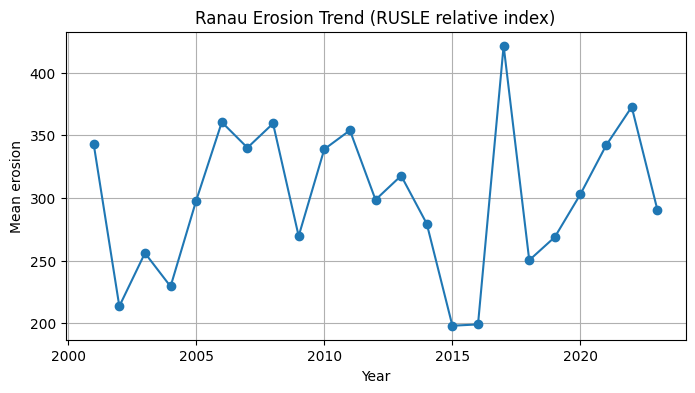

In [ ]:
summary = []
for y in years_sorted:
    A = load_tif(erosion_paths[y])
    summary.append({
        "year": y,
        "mean": float(np.nanmean(A)),
        "median": float(np.nanmedian(A)),
        "p90": float(np.nanpercentile(A, 90)),
        "p95": float(np.nanpercentile(A, 95))
    })

summary_df = pd.DataFrame(summary).sort_values("year")
display(summary_df)

plt.figure(figsize=(8,4))
plt.plot(summary_df["year"], summary_df["mean"], marker="o")
plt.title("Ranau Erosion Trend (RUSLE relative index)")
plt.xlabel("Year")
plt.ylabel("Mean erosion")
plt.grid(True)
plt.show()

## Objective 3 — High-Risk Zone Mapping
We classify erosion into risk classes using quantiles:

- Low → Moderate → High → Very High → Extreme

**Output**
- `erosion_risk_YYYY.tif`


In [ ]:
risk_year = years_sorted[-1]
A_risk = load_tif(erosion_paths[risk_year])

q50, q75, q90, q97 = np.nanquantile(A_risk, [0.5, 0.75, 0.90, 0.97])

risk = np.zeros_like(A_risk, dtype=np.uint8)
risk[np.isnan(A_risk)] = 0
risk[(A_risk <= q50)] = 1
risk[(A_risk > q50) & (A_risk <= q75)] = 2
risk[(A_risk > q75) & (A_risk <= q90)] = 3
risk[(A_risk > q90) & (A_risk <= q97)] = 4
risk[(A_risk > q97)] = 5

risk_prof = dem_prof.copy()
risk_prof.update(dtype=rasterio.uint8, nodata=0, compress="lzw")

risk_path = os.path.join(OUT_DIR, f"erosion_risk_{risk_year}.tif")
with rasterio.open(risk_path, "w", **risk_prof) as dst:
    dst.write(risk, 1)

print("Saved risk map:", risk_path)

Saved risk map: ranau_outputs/erosion_risk_2023.tif


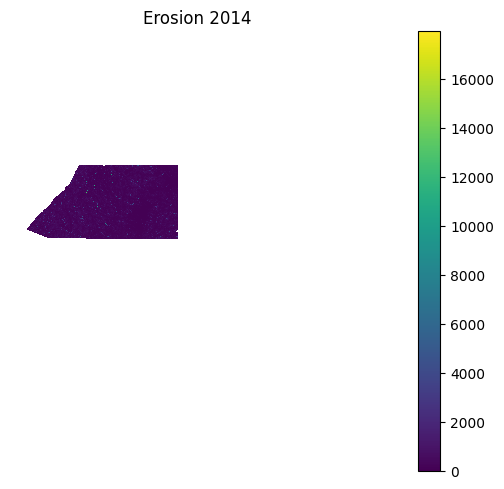

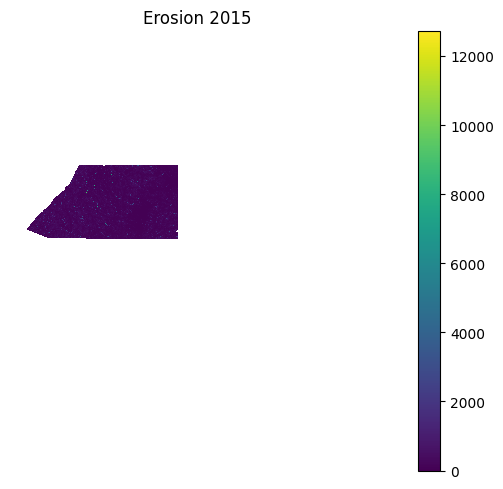

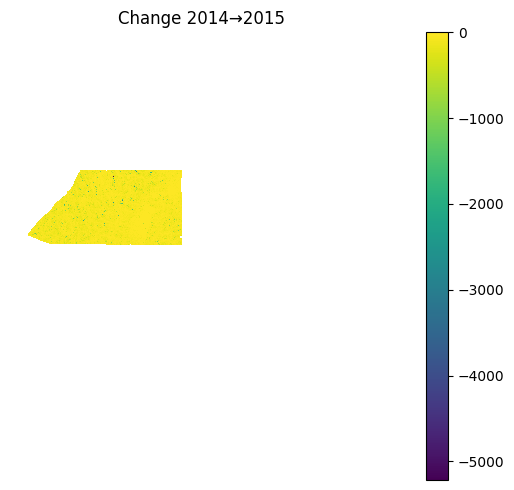

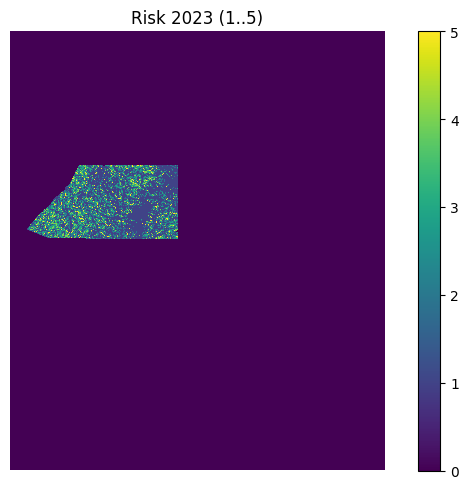

In [ ]:
def plot_and_save(arr, title, out_png):
    plt.figure(figsize=(7,5))
    plt.imshow(arr, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()

plot_and_save(A_pre,  f"Erosion {pre_year}",  os.path.join(OUT_DIR, f"erosion_{pre_year}.png"))
plot_and_save(A_post, f"Erosion {post_year}", os.path.join(OUT_DIR, f"erosion_{post_year}.png"))
plot_and_save(delta,  f"Change {pre_year}→{post_year}", os.path.join(OUT_DIR, f"change_{pre_year}_{post_year}.png"))
plot_and_save(risk,   f"Risk {risk_year} (1..5)", os.path.join(OUT_DIR, f"risk_{risk_year}.png"))

## Outputs Checklist
- Terrain: `slope_deg.tif`, `flowacc_cells.tif`, `LS_factor.tif`
- Factors: `K_factor.tif`, `C_factor.tif`, `P_factor.tif`
- Annual erosion maps: `erosion_RUSLE_YYYY.tif`
- Change maps: `erosion_change_*.tif`, `erosion_pctchange_*.tif`
- Risk map: `erosion_risk_YYYY.tif`
- Figures: PNG maps + trend plot
